# Часть 3. Детекция

В этом ноутбуке мы попробуем сдетектировать скважины на фотографиях. Для этого также вручную была произведена разметка с детекцией. Импортируем csv-файл с разметкой

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Nemezida UAV/df_annot.csv')
df = df[df.filename.str.startswith('Скважины')]
df.head()

,filename,x0,y0,x1,y1,label
0,Скважины без разливов (52).JPG,4533,1309,5005,1745,Скважина
1,Скважины без разливов (52).JPG,4449,1777,4833,2065,Скважина
2,Скважины без разливов (52).JPG,4573,3165,4881,3397,Скважина
3,Скважины без разливов (53).JPG,481,2975,871,3261,Скважина
4,Скважины без разливов (53).JPG,3018,3451,3380,3701,Скважина


In [24]:
df.shape

(114, 6)

Разметка содержит в каждой строке название файла а также информацию о детектированном объекте: название класса (label), координаты левого верхнего угла охватывающего прямоугольника (x0, y0) и координаты правого нижнего угла (x1, y1). Всего размечено 114 скважин.

Сгруппируем наши данные по столбцу названия файла, для удобства

In [26]:
df = df.groupby('filename').apply(lambda x: list(x.iloc[:, 1:].values))
df.head()

filename
Скважины без разливов (1).JPG                  [[1114, 1830, 1507, 2115, Скважина]]
Скважины без разливов (10).JPG    [[2329, 2762, 2686, 3105, Скважина], [1868, 28...
Скважины без разливов (11).JPG                 [[3294, 2213, 3825, 2623, Скважина]]
Скважины без разливов (12).JPG    [[4672, 2061, 5328, 2629, Скважина], [4431, 31...
Скважины без разливов (13).JPG                     [[556, 23, 1113, 452, Скважина]]
dtype: object

Посмотрим, как выглядит разметка на картинке

Скважины без разливов (29).JPG


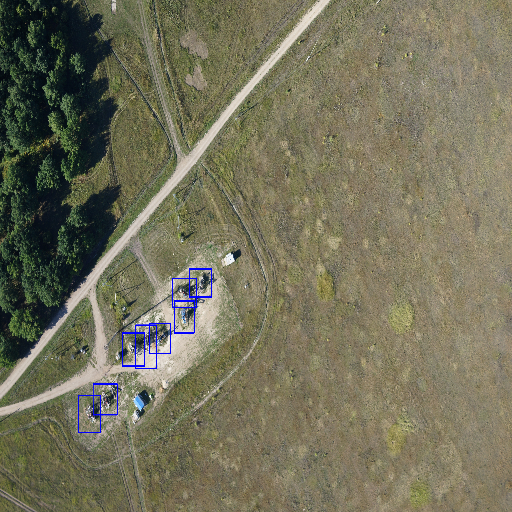

In [69]:
from google.colab.patches import cv2_imshow

base_path = '/content/drive/MyDrive/Nemezida UAV/Фото без отклонений/Скважины без разливов/{}'
name = 'Скважины без разливов (29).JPG'

img = cv.imread(base_path.format(name))

for bbox in df[name]:
    x1, y1, x2, y2 = bbox[:4].astype(int)
    img = img.copy()
    img = cv.rectangle(img, (x1, y1), (x2,y2), color=(255, 0, 0), thickness=10)
print(name)
cv2_imshow(cv.resize(img, (512,512)))

Поделим данные на тренировочную и тестовую выборки

In [31]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.25, random_state=0)

Для детектирования будем пользоваться библиотекой mmdetection. Установим её

In [1]:
!pip install mmcv-full

!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

!pip install Pillow==7.0.0

     |████████████████████████████████| 225kB 5.6MB/s eta 0:00:01
     |████████████████████████████████| 194kB 24.0MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.2.5-cp36-cp36m-linux_x86_64.whl size=20542999 sha256=8498695b2313dc638f94dc2b80bfae3abbbacf74f4b33decfb95e61849ecff21
  Stored in directory: /root/.cache/pip/wheels/1e/6a/d1/a824675d02cbe25db916fa987e87df21983bb75b3bb36cf4d0
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 14924 (delta 3), reused 2 (delta 0), pack-reused 14907
Receiving objects: 100% (14924/14924), 16.61 MiB | 8.48 MiB/s, done.
Resolving deltas: 100% (10197/10197), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp36-cp36m-linux_x86_64.whl size=265913 sha256=8ad1336f040fcc258a4c3a770616b383644d6308b5f3ad65ed1b279

In [2]:
import torch, torchvision
import mmdet

Будем использовать предобученную модель mask_rcnn. Скачаем её веса

In [3]:
!mkdir checkpoints
!wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2021-01-04 15:33:26--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.56.151
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.56.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  15.5MB/s    in 12s     

2021-01-04 15:33:39 (13.8 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]

In [20]:
%cd /content

/content


Создадим класс WellDataset, который будет генерировать аннотации в формате MMDetection:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [32]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class WellDataset(CustomDataset):

    CLASSES = ('Скважина',)

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.JPG'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.JPG', width=width, height=height)

            label_prefix = 'label_2'
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:5]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=None,
                labels_ignore=None,
            )
                # bboxes_ignore=np.array(gt_bboxes_ignore,
                #                        dtype=np.float32).reshape(-1, 4),
                # labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

Создадим дополнительные аннотационные файлы

In [33]:
print('\n'.join(i[:-4] for i in df_train.index), file=open('train.txt', 'w'))
print('\n'.join(i[:-4] for i in df_val.index), file=open('val.txt', 'w'))

In [34]:
import os
os.makedirs('label_2', exist_ok=True)

In [35]:
for name, bboxes in df.iteritems():
    to_put = ''
    for bbox in bboxes:
        x0, y0, x1, y1, label = bbox
        line = [label, x0, y0, x1, y1]
        to_put += ' '.join(map(str, line)) + '\n'
        print(to_put, file=open('label_2/'+name[:-4]+'.txt', 'w'))

Перейдём к настройке конфига

In [36]:
from mmcv import Config
cfg = Config.fromfile('mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [37]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'WellDataset'
cfg.data_root = '.'

cfg.data.test.type = 'WellDataset'
cfg.data.test.data_root = '.'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = '/content/drive/MyDrive/Nemezida UAV/Фото без отклонений/Скважины без разливов'

cfg.data.train.type = 'WellDataset'
cfg.data.train.data_root = '.'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = '/content/drive/MyDrive/Nemezida UAV/Фото без отклонений/Скважины без разливов'

cfg.data.val.type = 'WellDataset'
cfg.data.val.data_root = '.'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = '/content/drive/MyDrive/Nemezida UAV/Фото без отклонений/Скважины без разливов'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
cfg.load_from = 'mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = 'mmdetection/tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 4
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

In [38]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


datasets = [build_dataset(cfg.data.train)]

model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection/mmdet/datasets/custom.py:154: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2021-01-04 15:45:21,359 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_msra-5891d200.pth" to /root/.cache/torch/hub/checkpoints/resnet50_msra-5891d200.pth


2021-01-04 15:45:27,857 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias



2021-01-04 15:46:15,289 - mmdet - INFO - load checkpoint from mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2021-01-04 15:46:15,433 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
unexpected key in source state_dict: roi_head.mask

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 1.4 task/s, elapsed: 8s, ETA:     0s

2021-01-04 15:48:24,659 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| Скважина | 29  | 155  | 0.897  | 0.623 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.623 |
+----------+-----+------+--------+-------+
2021-01-04 15:48:24,663 - mmdet - INFO - Epoch(val) [4][19]	mAP: 0.6229
2021-01-04 15:48:43,591 - mmdet - INFO - Epoch [5][10/19]	lr: 2.500e-03, eta: 0:02:28, time: 1.819, data_time: 0.708, memory: 3320, loss_rpn_cls: 0.0040, loss_rpn_bbox: 0.0122, loss_cls: 0.1332, acc: 94.0039, loss_bbox: 0.2540, loss: 0.4033
2021-01-04 15:49:13,376 - mmdet - INFO - Epoch [6][10/19]	lr: 2.500e-03, eta: 0:02:05, time: 1.766, data_time: 0.535, memory: 3320, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0120, loss_cls: 0.1240, acc: 94.8535, loss_bbox: 0.2438, loss: 0.3819
2021-01-04 15:49:43,211 - mmdet - INFO - Epoch [7][10/19]	lr: 2.500e-03, eta: 0:01:44, time: 1.764, dat

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 1.4 task/s, elapsed: 8s, ETA:     0s

2021-01-04 15:50:33,879 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| Скважина | 29  | 128  | 0.897  | 0.715 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.715 |
+----------+-----+------+--------+-------+
2021-01-04 15:50:33,882 - mmdet - INFO - Epoch(val) [8][19]	mAP: 0.7151
2021-01-04 15:50:52,091 - mmdet - INFO - Epoch [9][10/19]	lr: 2.500e-04, eta: 0:01:05, time: 1.752, data_time: 0.568, memory: 3320, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0080, loss_cls: 0.1099, acc: 95.3516, loss_bbox: 0.1958, loss: 0.3147
2021-01-04 15:51:22,388 - mmdet - INFO - Epoch [10][10/19]	lr: 2.500e-04, eta: 0:00:46, time: 1.757, data_time: 0.517, memory: 3320, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0131, loss_cls: 0.1150, acc: 95.5566, loss_bbox: 0.2307, loss: 0.3619
2021-01-04 15:51:52,935 - mmdet - INFO - Epoch [11][10/19]	lr: 2.500e-04, eta: 0:00:27, time: 1.818, d

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 1.5 task/s, elapsed: 8s, ETA:     0s

2021-01-04 15:52:44,544 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| Скважина | 29  | 71   | 0.759  | 0.681 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.681 |
+----------+-----+------+--------+-------+
2021-01-04 15:52:44,548 - mmdet - INFO - Epoch(val) [12][19]	mAP: 0.6806


В итоге accuracy оказалось равным 97%, recall в 76-80%, mAP - 68%, что довольно неплохие результаты.

Визуализируем предсказания какой-нибудь картинки из валидационной выборки

In [42]:
df_val

filename
Скважины без разливов (53).JPG    [[481, 2975, 871, 3261, Скважина], [3018, 3451...
Скважины без разливов (13).JPG                     [[556, 23, 1113, 452, Скважина]]
Скважины без разливов (4).JPG                  [[2513, 1824, 3104, 2299, Скважина]]
Скважины без разливов (54).JPG                    [[147, 647, 517, 1009, Скважина]]
Скважины без разливов (56).JPG    [[3351, 1178, 3817, 1600, Скважина], [4953, 19...
Скважины без разливов (60).JPG    [[969, 3281, 1289, 3553, Скважина], [2265, 152...
Скважины без разливов (58).JPG    [[5681, 2401, 5977, 2641, Скважина], [5649, 26...
Скважины без разливов (63).JPG                 [[2377, 2921, 2777, 3209, Скважина]]
Скважины без разливов (17).JPG    [[3, 370, 245, 585, Скважина], [178, 513, 431,...
Скважины без разливов (2).JPG     [[4483, 1229, 4892, 1620, Скважина], [4840, 14...
Скважины без разливов (20).JPG                   [[480, 670, 1020, 1175, Скважина]]
Скважины без разливов (55).JPG                 [[3645, 2613, 4013, 

В стандартной функции для визуализации предсказаний show_result_pyplot из mmdetection не были видны охватывающие прямоугольники на большой картинке. Изменять их ширину нельзя, поэтому напишем свою функцию show_result_custom.

In [56]:
from google.colab.patches import cv2_imshow
import cv2 as cv
import numpy as np

def show_result_custom(img, result, thr=0.5):
    for idx, bboxes in enumerate(result):
        for bbox in bboxes:
            x1, y1, x2, y2, _ = bbox.astype(int)
            if bbox[-1] > thr:
                img = img.copy()
                img = cv.rectangle(img, (x1, y1), (x2,y2), color=(255, 0, 0), thickness=9)
    img = cv.resize(img, (1024, 1024))
    cv2_imshow(img)

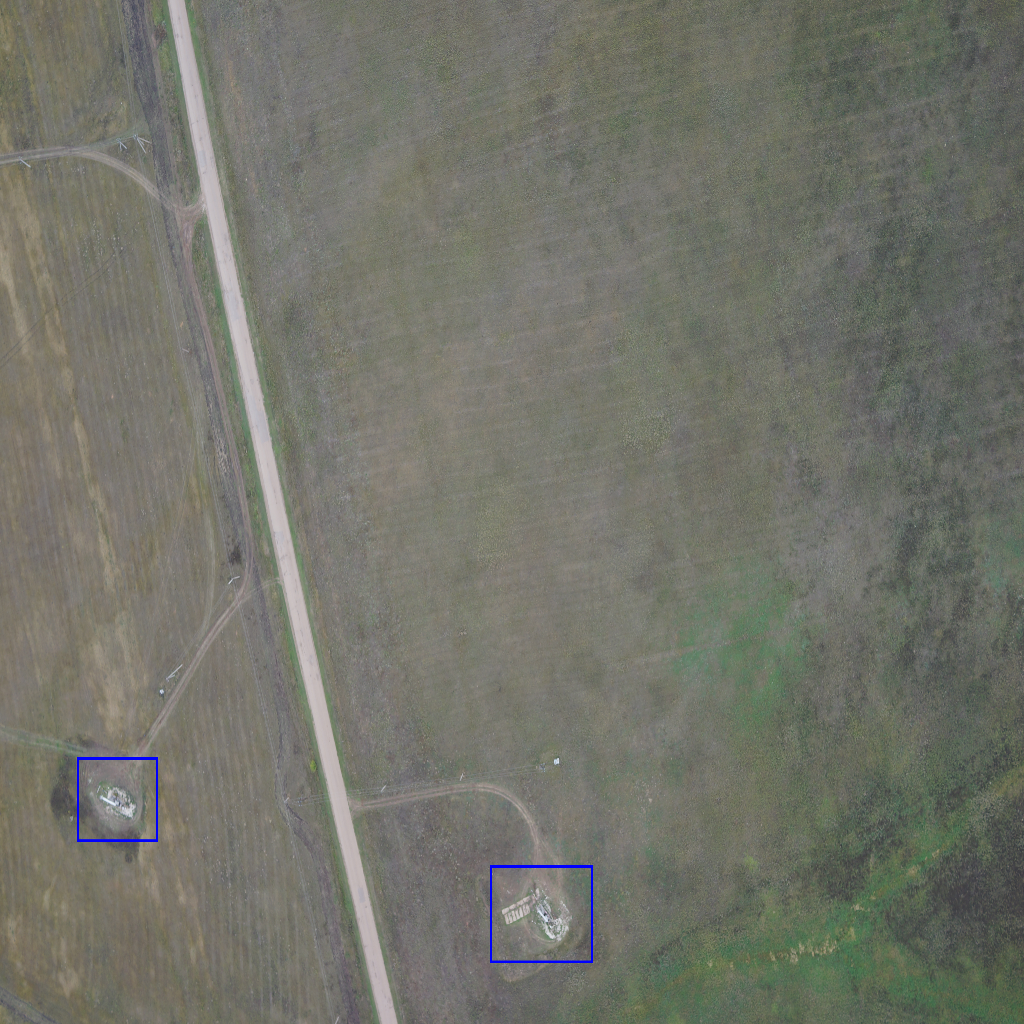

In [57]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot


name = '/content/drive/MyDrive/Nemezida UAV/Фото без отклонений/Скважины без разливов/Скважины без разливов (53).JPG'
img = mmcv.imread(name)
model.cfg = cfg
result = inference_detector(model, img)

show_result_custom(img, result)

Видим, что скважины отлично детектируются

### Заключение

Мы сделали большой путь в области распознвания изображений с применением свёрточных нейронных сетей. Начали со стандартной классификации объектов на фотография; далее перешли на сегментацию, а также использовали идею автоэнкодеров для поиска аномальных наблюдений. В конце концов мы пришли к детектированию, которое неплохо показало себя в нашей задаче. Таким образом, можно сделать вывод, что даже с таким небольшим набором данных изображений можно получить неплохие результаты.